# Heatmap de Activación por clase en ConvNets

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

A veces se quiere saber las partes de una imagen que fueron mas influyentes en su clasificación a partir de una red convolucional en una clase determinada. Esto permite por ejemplo realizar localización de objetos.

Estas técnicas se conocen como visualizaciones CAM (class activation map), y consiste en generar heatmaps de la activación de una clase sobre las imágenes de entrada, indicando qué tan importante cada ubicación es con respecto a la clase en consideración.

Vamos a utilizar la implementación de "Grad-CAM: Visual Explanations from Deep Networkds via Gradient-based Localization", que consiste en tomar el feature map de salida de una capa convolucional, dada una imagen de entrada, dándole un peso a cada canal del feature map a partir del gradiente de la clase con respecto al canal.

## Carga de modelo y pretratamiento de imagen a analizar

Vamos a utilizar el modelo VGG16, previamente entrenado con ImageNet, al que le vamos a presentar en entrada una imagen de unos elefantes en una sabana, que se debe reescalar para que tenga un tamaño de 224x224 y un tipo float32, correspondiente a los inputs de VGG16.

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

model = VGG16(weights='imagenet')

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

import numpy as np

img_path = 'C:/Users/Javier/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/female-elephant-341983_1280.jpg'

# Se carga la imagen con el tamaño indicado
img = image.load_img(img_path, target_size=(224, 224)) 
# Se transforma la imagen a un tensor (224, 224, 3) de tipo float
x = image.img_to_array(img)
print(x.shape)
# Se agrega un eje y queda (1, 224, 224, 3)
x = np.expand_dims(x, axis=0) 
# Se normaliza por cada canal de color
x = preprocess_input(x) 
print(x.shape)

(224, 224, 3)
(1, 224, 224, 3)


## Predicción de la clase

Ahora vamos a correr el modelo pre entrenado con la image y decodificar el vector de predicción para que sea fácil de entender.

In [4]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top = 3)) # se imprimen las primeras 3 clases

print(model.output.shape)

Predicted:  [[('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.004354581)]]
(?, 1000)


La clase más importante es la de `African_elephant`, con una probabilidad de 90.4%, seguida por `tusker` con el 8.6% y luego por `Indian_elephant` con 0.4%. Vamos a ver la primera clase que posición tiene en el array de 1000 clases.

In [5]:
np.argmax(preds[0])

386

## Proceso de gradiente CAM

Vamos a obtener la entrada de la clase con índice 386 en el vector de predicción y el feature map de salida de la última capa convolucional, y sucesivamente obtener los gradientes de la clase de elefante africano con respecto al feature map de salida.

In [6]:
from keras import backend as K

african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
print(grads)

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)


Del tensor de gradientes obtenemos el promedio de las intensidades de los gradientes de cada feature map.
La última capa convolucional incluye 512 filtros, por lo que obtenemos un tensor con 1 eje de 512 dimensiones.

In [7]:
pooled_grads = K.mean(grads, axis=(0,1,2))
print(pooled_grads)

pooled_grads

Tensor("Mean:0", shape=(512,), dtype=float32)


<tf.Tensor 'Mean:0' shape=(512,) dtype=float32>

Vamos ahora a realizar las iteraciones del gradient descent.

In [8]:
# Definimos una función de backend que para cada tensor de entrada obtenga:
# - los primedios de los gradientes de cada canal de la última capa convolucional
# - el feature map de la última capa convolucional
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

print(pooled_grads_value.shape)
print(conv_layer_output_value.shape)

(512,)
(14, 14, 512)


Ahora vamos a iterar por cada filtro, modificando el feature map de activación de cada filtro por la importancia del filtro, según lo califica el valor del gradiente.

Calculamos el heatmap como el promedio de los feature maps ponderados

In [9]:
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap.shape)
print(heatmap[:5, :5])

(14, 14)
[[ 6.0111540e-07  3.3704339e-07  7.0213594e-07  7.1817715e-07
   5.6608258e-07]
 [ 3.5244003e-07  2.1553790e-08  1.7741544e-07  5.0791840e-08
  -1.4305965e-07]
 [ 9.0117510e-07  4.3984642e-07  3.5481341e-07  2.4186920e-07
   3.4737309e-07]
 [ 1.1769390e-06  5.4644215e-07  1.9998583e-07  5.0972631e-08
   3.6513057e-07]
 [ 1.1271549e-06  5.5549543e-07  3.4628505e-07  6.6478032e-07
   2.4283404e-06]]


Para poder visualizar las imágenes, se normaliza el heatmap en un rango [0, 1]

In [10]:
# Se cortan valores negativos y se ponen en 0.
heatmap = np.maximum(heatmap, 0)
# Se divide por el max  para que todo quede en el rango [0, 1]
heatmap /= np.max(heatmap)
print(heatmap.shape)
print(heatmap[:5, :5])

(14, 14)
[[0.05023633 0.02816734 0.0586788  0.0600194  0.04730857]
 [0.02945407 0.00180129 0.01482694 0.00424477 0.        ]
 [0.07531288 0.03675878 0.02965241 0.02021346 0.02903061]
 [0.09835898 0.04566719 0.01671319 0.00425988 0.03051464]
 [0.09419843 0.04642379 0.02893968 0.05555693 0.20294091]]


In [11]:
import matplotlib.pyplot as plt
plt.matshow(heatmap)

Esta imagen de 14x14 nos muestra el heatmap de activación de la clase elefante africano sobre la imagen de entrada. 
Ahora vamos a utilizar OpenCV para generar una imagen que sobreimpone la imagen original sobre el heatmap.

In [12]:
import cv2

In [13]:
img = cv2.imread(img_path) #carga la imagen original usando cv2
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) #convierte el heatmap a RGB

# Aplica el heatmap a la imagen original
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap*0.4 + img # se utiliza un factor de intensidad del heatmap de 0.4

cv2.imwrite('C:/Users/Javier/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/female-elephant-heatmap.jpg', 
            superimposed_img)

True

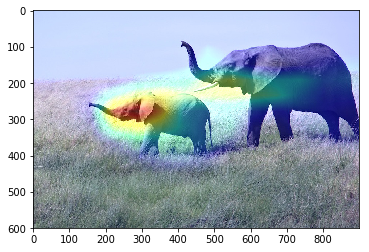

In [14]:
img_modif = image.load_img('C:/Users/Javier/Dropbox/Cursos_Propios/MIT - Deep Learning/05 - CNNs/female-elephant-heatmap.jpg') 
plt.imshow(img_modif)